# A simple 5-parameter $w_a$ blinded fit

### ROOT and blinding functions import
See https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Library_installation for a local installation of Blinding libraries for Python3

In [1]:
import sys, math 
sys.path.append("/usr/local/Cellar/root/6.16.00_3/lib/root") # add brew ROOT (Mac) the system path ($JUPYTER_PATH)
sys.path.append("Blinding/") # folder with Blinders and libBlinders.so
import ROOT as r
from ROOT import TFile, TStyle, TCanvas, gStyle, TF1, gROOT, TMath, TLegend
r.gROOT.Macro("~/rootlogon.C") #if you have a rootlogon.C / g2PlotStyle https://cdcvs.fnal.gov/redmine/projects/g-2/wiki/PlotStyleGuide
gStyle.SetOptStat(0) # we only want the event number in range (i.e. integral)
gStyle.SetOptFit(0) # use legend to put fit details 
c = TCanvas("c", "", 1800, 800) 
from BlindersPy3 import Blinders
from BlindersPy3 import FitType

Welcome to JupyROOT 6.16/00


### Set blinding here

In [2]:
# unblinded instance (for testing-only!)
# getBlinded = Blinders(FitType.Omega_a) # this will scream "You are not blind!"
# blinded=False

# blinded instance with your favorite phrase
getBlinded = Blinders(FitType.Omega_a, "EDM all day") # will tell you that you are blinded
blinded=True 

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


### Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency  
[4] $\phi$ is the initial phase  

In [3]:
def blinded_wiggle_function(x, pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
    R     = pars[3]
    phi   = pars[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    return norm * math.exp(-time/life) * (1 + asym*math.cos(omega*time + phi))

### Open ROOT file with a wiggle histogram and set some cuts (time)

In [4]:
file= "/Users/gleb/software/EDMTracking/trackRecoPlots_16145_16234.root"
path =  "TrackSummary/FitResults/Times_gt_1800MeV" # plot path in the ROOT file 
xmin=30 # us 
xmax=150 # us 
t_file = TFile.Open(file) 
h_wiggle = t_file.Get(path)

## Display the wiggle histogram

5827722 tracks in range 30 to 150 [us]


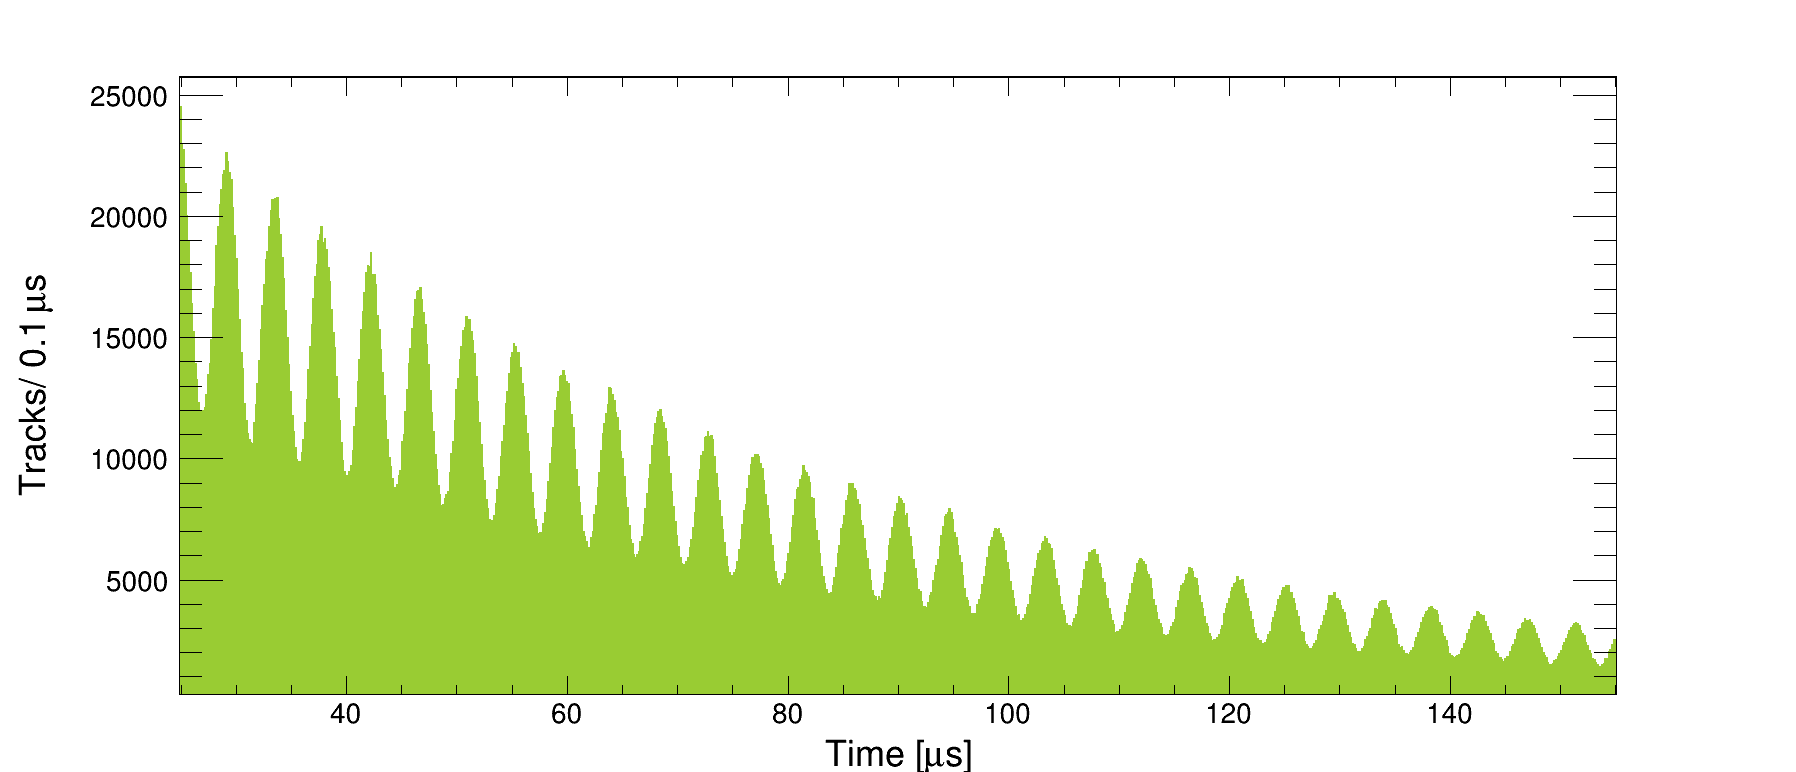

In [5]:
h_wiggle.Draw()
Xaxis = h_wiggle.GetXaxis()
Yaxis = h_wiggle.GetYaxis()
Xaxis.SetRangeUser(xmin-5, xmax+5) # apply the time cut (display purpose only +/-5 us to see start/end of the fit)
# Find the number of events in range
bmin = Xaxis.FindBin(xmin)
bmax = Xaxis.FindBin(xmax)
entries = h_wiggle.Integral(bmin,bmax)
print(int(entries), "tracks in range",xmin,"to",xmax,"[us]")
binW=h_wiggle.GetBinWidth(1) 
Xaxis.SetTitle("Time [#mus]")
h_wiggle.GetYaxis().SetTitle("Tracks/ %.1f #mus" % binW)
Xaxis.CenterTitle()
Yaxis.CenterTitle()
c.Draw()

## Now we can set some initial guess on the parameters and do a blinded fit

In [6]:
func = TF1("func", blinded_wiggle_function, xmin, xmax, 5) # use our defined function in range with 5 parameters
func.SetParNames('N','#tau','A','R','#phi') # name the parameters 
func.SetParameters(20000, 64.4 , 0.4 ,0.0, 0.0) # initial guess 
func.SetLineColor(2) # red 
func.SetNpx(10000) # prevent under-sampling (display only)
if(blinded==False):
    print("You are not blinded!")

## Now we can set some initial guess on the parameters and do a blinded fit

 FCN=1365.43 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         433 TOTAL
                     EDM=2.32672e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.69404e+04   2.78044e+01  -9.50578e-03  -2.08088e-08
   2  #tau         6.13723e+01   4.96712e-02   7.89120e-06  -6.89749e-07
   3  A            3.44587e-01   5.56785e-04  -4.08964e-07   8.56913e-05
   4  R           -6.80074e+01   3.64925e+01   7.35224e-04   3.72223e-08
   5  #phi         2.06438e+00   4.12065e-03   4.12065e-03   4.44898e-04


Info in <TCanvas::Print>: png file wiggle_blinded.png has been created


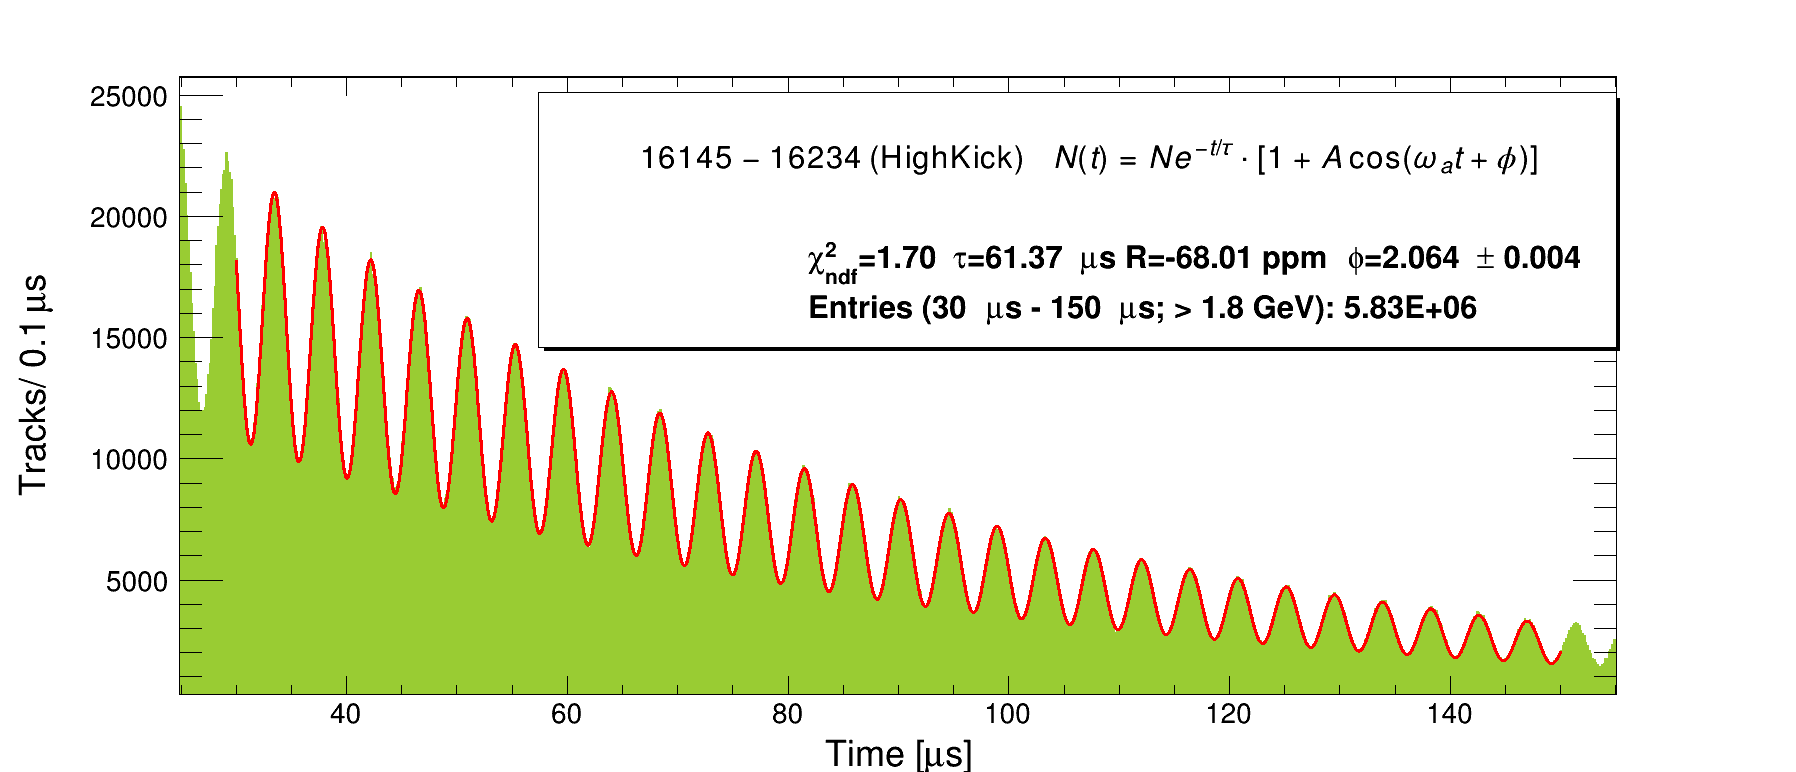

In [7]:
h_wiggle.Fit('func','REM') # fit in range (R), TMinut fit (M), Minos errors (E)

# Get the fit parameters
chi2=func.GetChisquare()
ndf=func.GetNDF()
ch2ndf=chi2/ndf
LT = func.GetParameter(1)
LT_error = func.GetParError(1)
R= func.GetParameter(3)
phi = func.GetParameter(4)
phi_error = func.GetParError(4)

# Set and draw legend
legend =  TLegend(0.3,0.55,0.90,0.88)
legend.SetHeader(r"16145-16234\,(\mathrm{HighKick}) \ N(t)=Ne^{-t/\tau} \cdot [1+A\cos(\omega_{a}t+\phi)]", "C")
legenValue1 = "#chi^{2}_{ndf}=%.2f #tau=%.2f #mus R=%0.2f ppm #phi=%.3f #pm %.3f" % (ch2ndf, LT, R, phi, phi_error)
legenValue2 = "Entries (30 #mus - 150 #mus; > 1.8 GeV): %.2E" % entries
legend.AddEntry(func, "#splitline{"+str(legenValue1)+"}{"+str(legenValue2)+"}", "")
gStyle.SetLegendBorderSize(0)
gStyle.SetLegendTextSize(0.044)
legend.Draw()

c.Draw()
c.SaveAs("wiggle_blinded.png")

In [13]:
r.enableJSVis()
# r.disableJSVis()

In [14]:
c.Draw()